# Phase 3: Interpolation Path Visualization

This notebook visualizes SLERP (Spherical Linear Interpolation) paths between centroid embeddings.

**Input Data:**
- 136 interpolation paths between centroids
- 21 steps per path (t = 0.0 to 1.0)
- Embedding dimension: 4096

**Visualizations:**
1. Path count summary per key
2. Angle distribution (theta) across all paths
3. Sample SLERP path: weather (foggy to clear)
4. Sample SLERP path: road_type (highway to intersection)
5. Path length vs angle scatter plot

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

# Configuration
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10

# Paths
DATA_DIR = Path('/Users/kaiser/Projects/Masterarbeit/data/runs/classification_20260120')
FIGURE_DIR = DATA_DIR / 'figures'
FIGURE_DIR.mkdir(exist_ok=True)

## Load Data

In [2]:
# Load interpolation paths
interp_data = np.load(DATA_DIR / 'interpolations.npz')
paths = interp_data['paths']  # (136, 21, 4096)
t_values = interp_data['t_values']  # (21,)

print(f'Paths shape: {paths.shape}')
print(f't values: {t_values}')

Paths shape: (136, 21, 4096)
t values: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In [3]:
# Load interpolation metadata
with open(DATA_DIR / 'interpolation_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f'Number of interpolation paths: {len(metadata)}')
print(f'Sample metadata entry: {metadata[0]}')

Number of interpolation paths: 136
Sample metadata entry: {'key': 'weather', 'value_a': 'foggy', 'value_b': 'clear', 'count_a': 1, 'count_b': 17, 'theta': 0.640773668255098, 'theta_deg': 36.71362681413305}


In [4]:
# Load centroids (for reference)
with open(DATA_DIR / 'centroids.json', 'r') as f:
    centroids_data = json.load(f)

print(f'Number of centroid entries: {len(centroids_data)}')

Number of centroid entries: 19


## 1. Path Count Summary by Key

Bar chart showing the number of interpolation paths for each attribute key.

In [5]:
# Count paths per key
key_counts = {}
for entry in metadata:
    key = entry['key']
    key_counts[key] = key_counts.get(key, 0) + 1

# Sort by count descending
sorted_keys = sorted(key_counts.items(), key=lambda x: x[1], reverse=True)
keys_sorted = [k for k, v in sorted_keys]
counts_sorted = [v for k, v in sorted_keys]

print('Paths per key:')
for k, c in sorted_keys:
    print(f'  {k}: {c}')

Paths per key:
  road_type: 30
  visual_degradation: 30
  weather: 12
  traffic_situation: 12
  occlusion_level: 12
  safety_criticality: 12
  required_action: 12
  time_of_day: 6
  pedestrians_present: 2
  construction_activity: 2
  traffic_signals_visible: 2
  depth_complexity: 2
  similar_object_confusion: 2


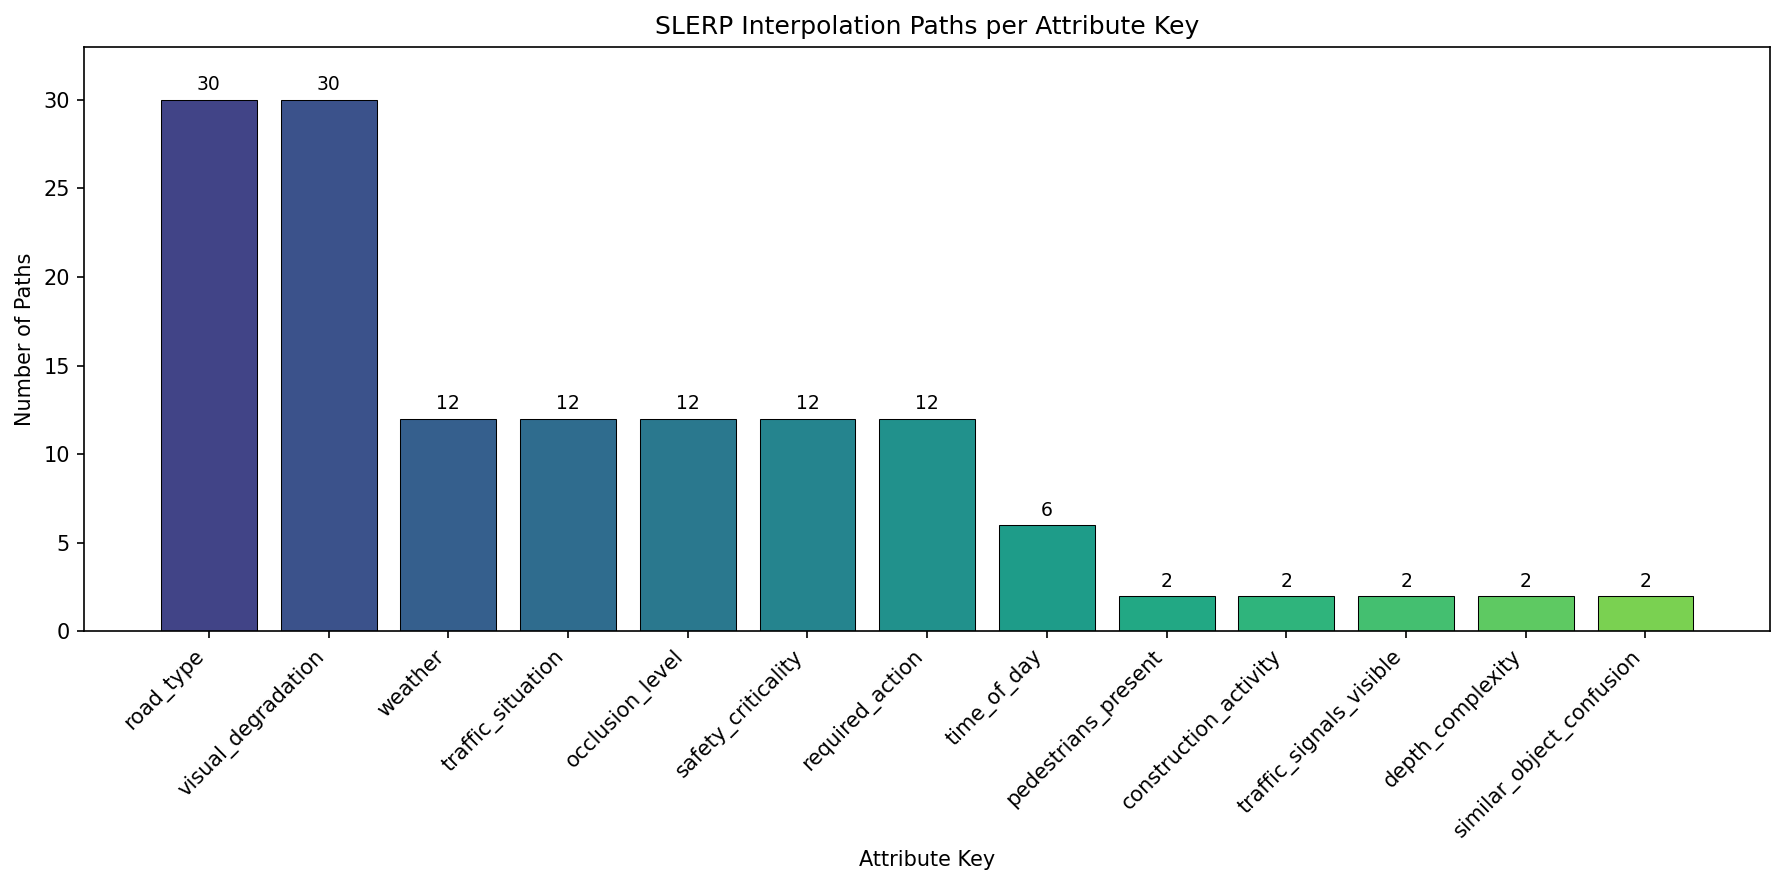

Total paths: 136


In [6]:
# Plot bar chart
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(keys_sorted)))
bars = ax.bar(range(len(keys_sorted)), counts_sorted, color=colors, edgecolor='black', linewidth=0.5)

ax.set_xticks(range(len(keys_sorted)))
ax.set_xticklabels(keys_sorted, rotation=45, ha='right')
ax.set_xlabel('Attribute Key')
ax.set_ylabel('Number of Paths')
ax.set_title('SLERP Interpolation Paths per Attribute Key')

# Add count labels on bars
for bar, count in zip(bars, counts_sorted):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            str(count), ha='center', va='bottom', fontsize=9)

ax.set_ylim(0, max(counts_sorted) + 3)
plt.tight_layout()

fig.savefig(FIGURE_DIR / '03_paths_per_key.png', bbox_inches='tight')
plt.show()

print(f'Total paths: {sum(counts_sorted)}')

## 2. Angle Distribution (Theta)

Histogram showing the distribution of angles (theta) between centroid pairs across all interpolation paths.

In [7]:
# Extract theta values (in degrees)
theta_degrees = [entry['theta_deg'] for entry in metadata]
theta_radians = [entry['theta'] for entry in metadata]

print(f'Theta range: {min(theta_degrees):.2f} to {max(theta_degrees):.2f} degrees')
print(f'Mean theta: {np.mean(theta_degrees):.2f} degrees')
print(f'Std theta: {np.std(theta_degrees):.2f} degrees')

Theta range: 16.46 to 46.45 degrees
Mean theta: 33.23 degrees
Std theta: 6.12 degrees


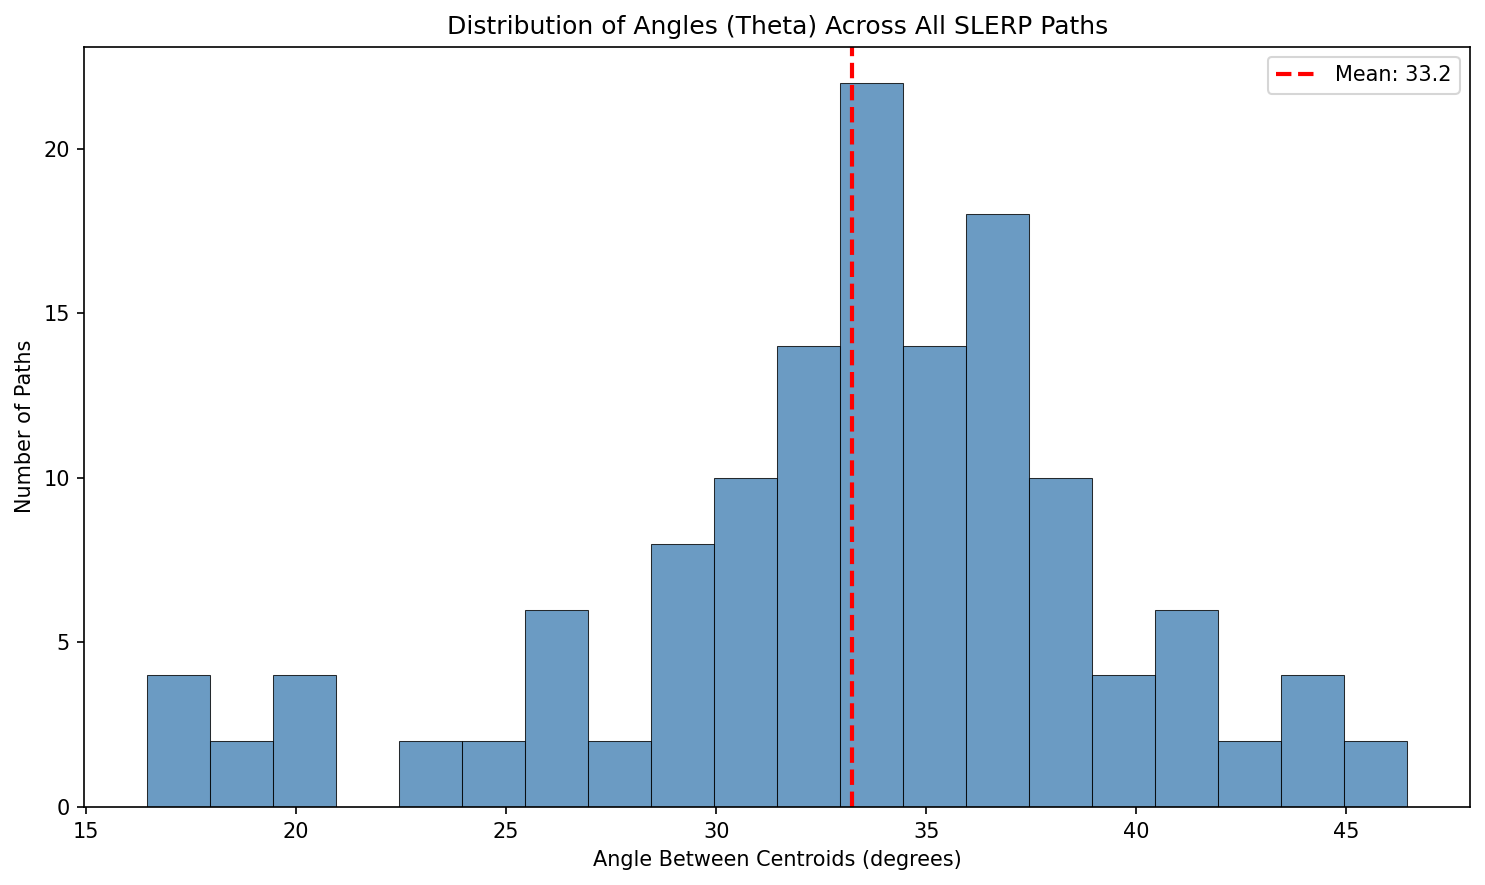

In [8]:
# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))

n, bins, patches = ax.hist(theta_degrees, bins=20, color='steelblue', 
                           edgecolor='black', linewidth=0.5, alpha=0.8)

# Add mean line
mean_theta = np.mean(theta_degrees)
ax.axvline(mean_theta, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_theta:.1f}')

ax.set_xlabel('Angle Between Centroids (degrees)')
ax.set_ylabel('Number of Paths')
ax.set_title('Distribution of Angles (Theta) Across All SLERP Paths')
ax.legend()

plt.tight_layout()
fig.savefig(FIGURE_DIR / '03_angle_distribution.png', bbox_inches='tight')
plt.show()

## 3. Sample SLERP Path: Weather (Foggy to Clear)

PCA projection of the interpolation path between the foggy and clear weather centroids.

In [9]:
def find_path_index(metadata, key, value_a, value_b):
    """Find the index of a specific interpolation path."""
    for i, entry in enumerate(metadata):
        if (entry['key'] == key and 
            entry['value_a'] == value_a and 
            entry['value_b'] == value_b):
            return i
    return None

def plot_slerp_path(path_idx, metadata, paths, save_name, title_suffix=''):
    """Visualize a SLERP path using PCA projection."""
    entry = metadata[path_idx]
    path = paths[path_idx]  # (21, 4096)
    
    # PCA on the path points
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(path)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create color gradient from start to end
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(path)))
    
    # Plot path as connected line
    ax.plot(coords[:, 0], coords[:, 1], 'k-', alpha=0.3, linewidth=1, zorder=1)
    
    # Plot points with color gradient
    scatter = ax.scatter(coords[:, 0], coords[:, 1], c=np.linspace(0, 1, len(path)),
                        cmap='coolwarm', s=80, edgecolors='black', linewidth=0.5, zorder=2)
    
    # Mark start and end points
    ax.scatter(coords[0, 0], coords[0, 1], c='blue', s=200, marker='s',
               edgecolors='black', linewidth=2, label=f'Start: {entry["value_a"]}', zorder=3)
    ax.scatter(coords[-1, 0], coords[-1, 1], c='red', s=200, marker='s',
               edgecolors='black', linewidth=2, label=f'End: {entry["value_b"]}', zorder=3)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Interpolation t (0=start, 1=end)')
    
    # Labels
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    title = f'SLERP Path: {entry["key"]} ({entry["value_a"]} to {entry["value_b"]})'
    if title_suffix:
        title += f'\n{title_suffix}'
    ax.set_title(title)
    ax.legend(loc='best')
    
    # Add theta annotation
    ax.annotate(f'Angle: {entry["theta_deg"]:.1f}',
                xy=(0.02, 0.98), xycoords='axes fraction',
                ha='left', va='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    fig.savefig(FIGURE_DIR / save_name, bbox_inches='tight')
    plt.show()
    
    return entry

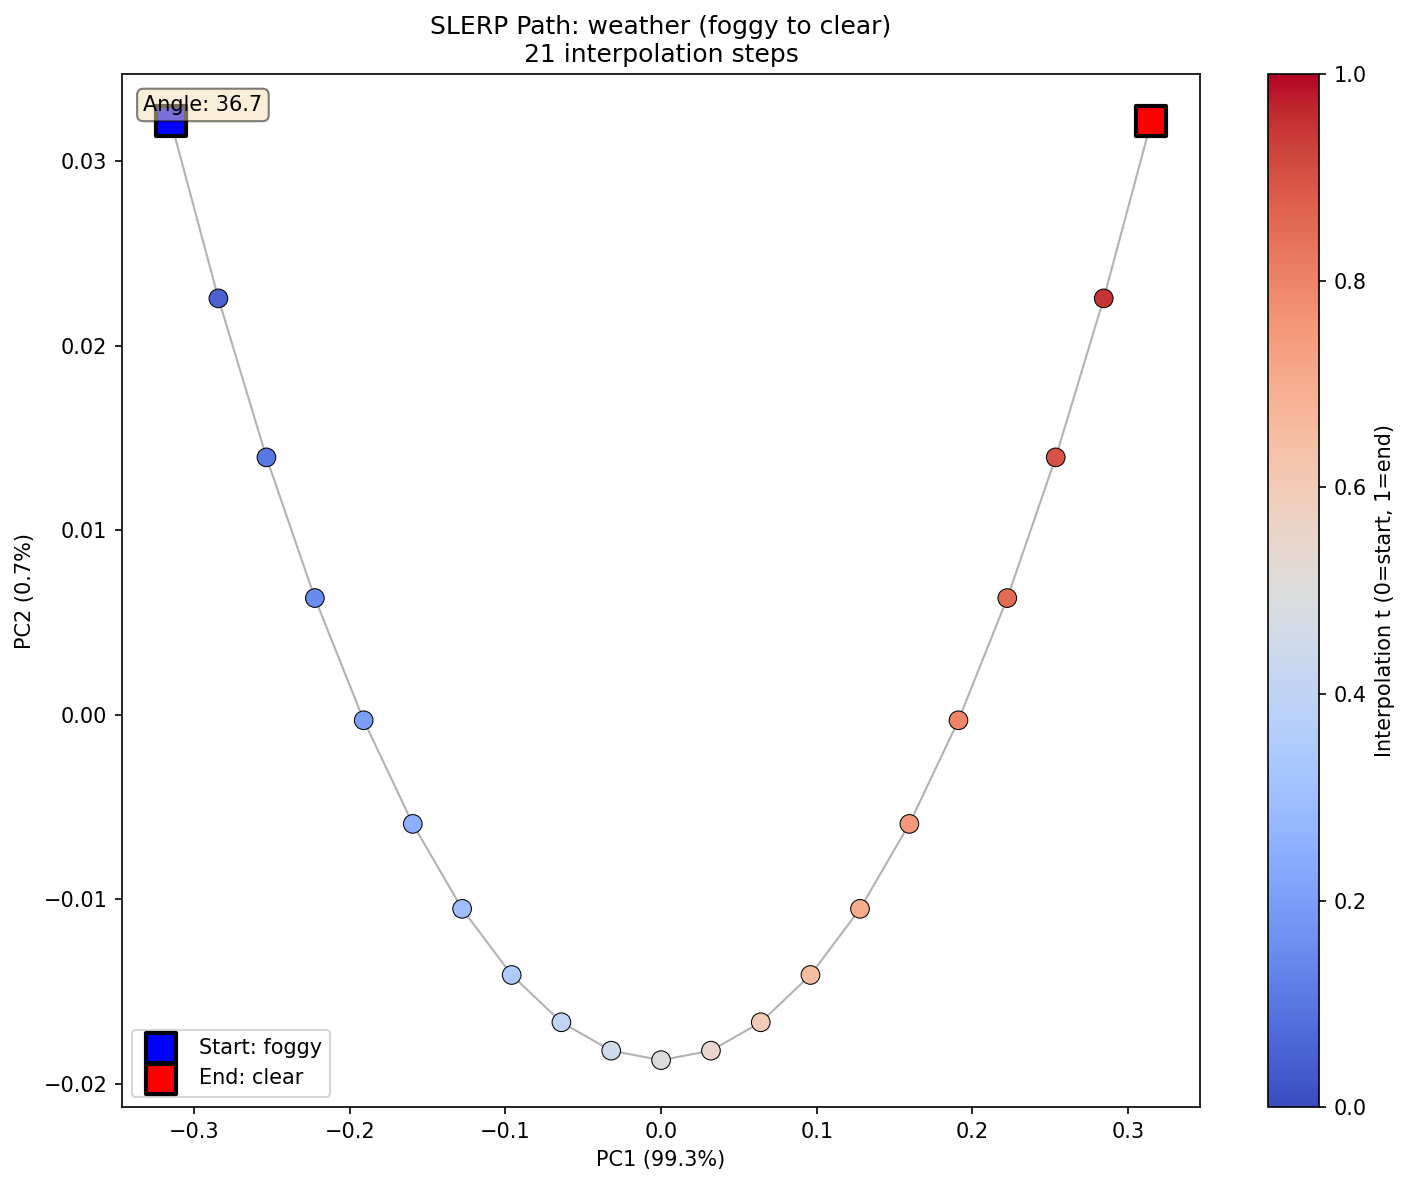

Path index: 0
Theta: 36.71 degrees


In [10]:
# Find and plot weather: foggy -> clear path
weather_idx = find_path_index(metadata, 'weather', 'foggy', 'clear')
if weather_idx is not None:
    entry = plot_slerp_path(weather_idx, metadata, paths, 
                            '03_path_weather_foggy_clear.png',
                            title_suffix='21 interpolation steps')
    print(f'Path index: {weather_idx}')
    print(f'Theta: {entry["theta_deg"]:.2f} degrees')
else:
    print('Path not found: weather foggy -> clear')

## 4. Sample SLERP Path: Road Type (Highway to Intersection)

PCA projection of the interpolation path between highway and intersection road type centroids.

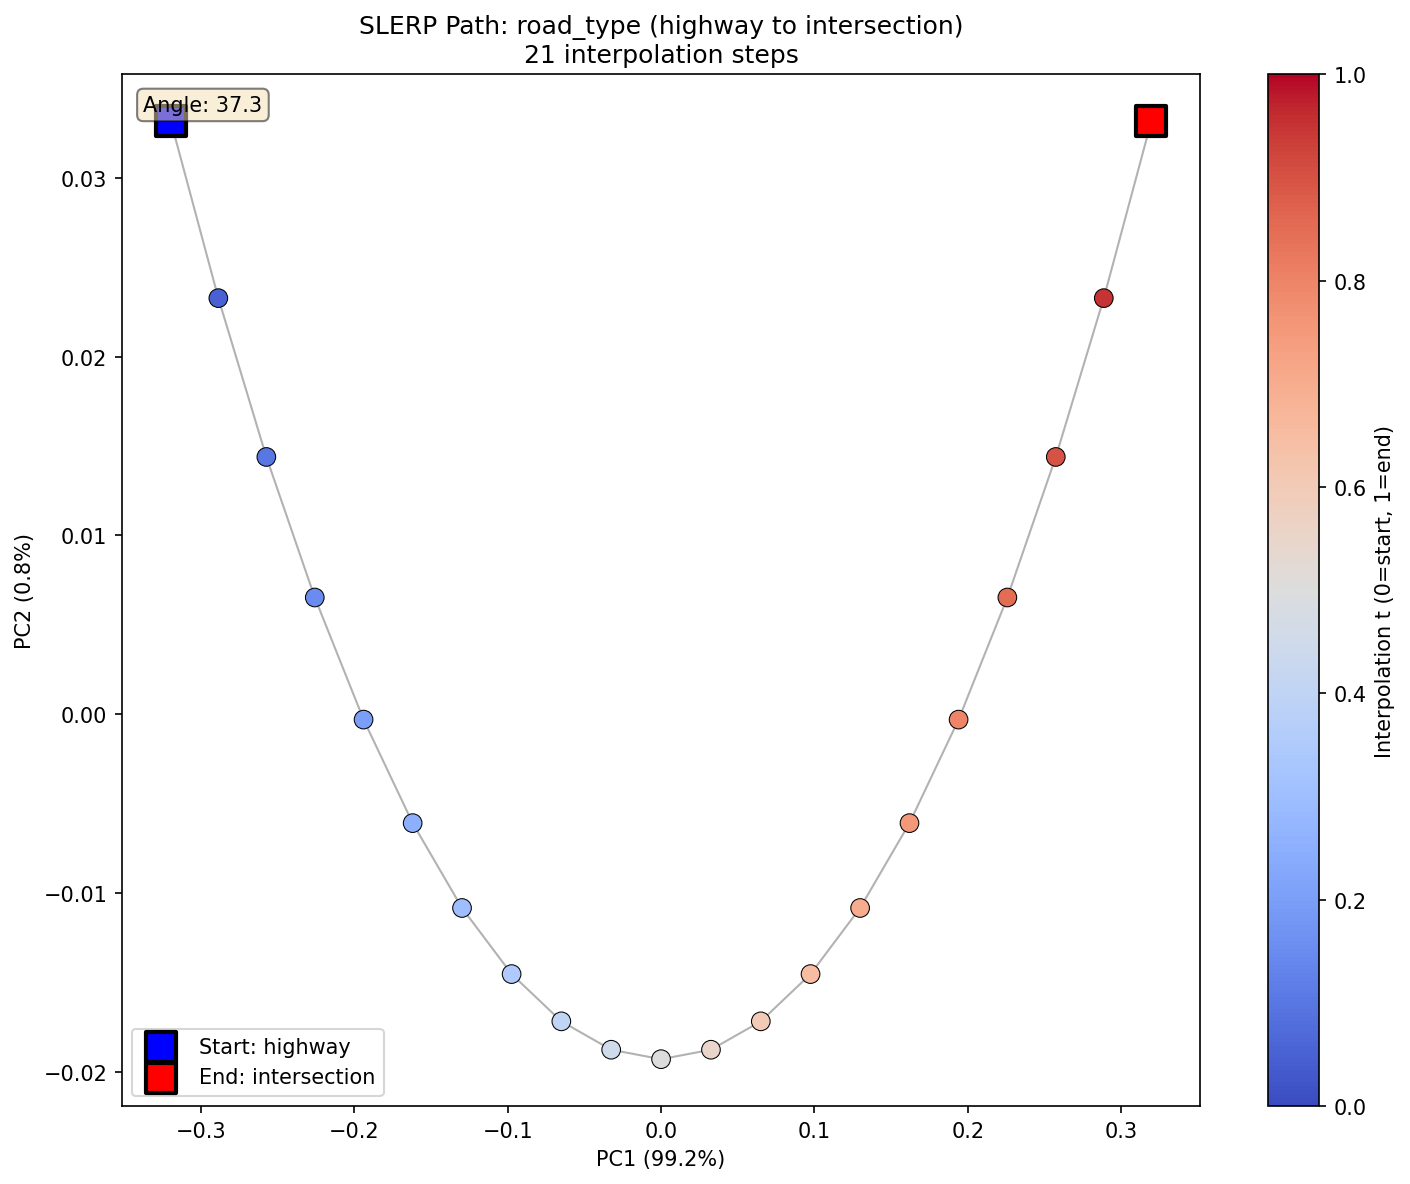

Path index: 20
Theta: 37.28 degrees


In [11]:
# Find and plot road_type: highway -> intersection path
road_idx = find_path_index(metadata, 'road_type', 'highway', 'intersection')
if road_idx is not None:
    entry = plot_slerp_path(road_idx, metadata, paths,
                            '03_path_road_highway_intersection.png',
                            title_suffix='21 interpolation steps')
    print(f'Path index: {road_idx}')
    print(f'Theta: {entry["theta_deg"]:.2f} degrees')
else:
    print('Path not found: road_type highway -> intersection')

## 5. Path Length vs Angle Scatter Plot

For each of the 136 paths, compute the arc length (sum of consecutive Euclidean distances) and plot against the angle between centroids.

In [12]:
def compute_arc_length(path):
    """Compute the arc length of a path (sum of Euclidean distances between consecutive points)."""
    total_length = 0.0
    for i in range(len(path) - 1):
        dist = np.linalg.norm(path[i+1] - path[i])
        total_length += dist
    return total_length

# Compute arc lengths for all paths
arc_lengths = [compute_arc_length(paths[i]) for i in range(len(metadata))]

print(f'Arc length range: {min(arc_lengths):.4f} to {max(arc_lengths):.4f}')
print(f'Mean arc length: {np.mean(arc_lengths):.4f}')

Arc length range: 0.2872 to 0.8107
Mean arc length: 0.5799


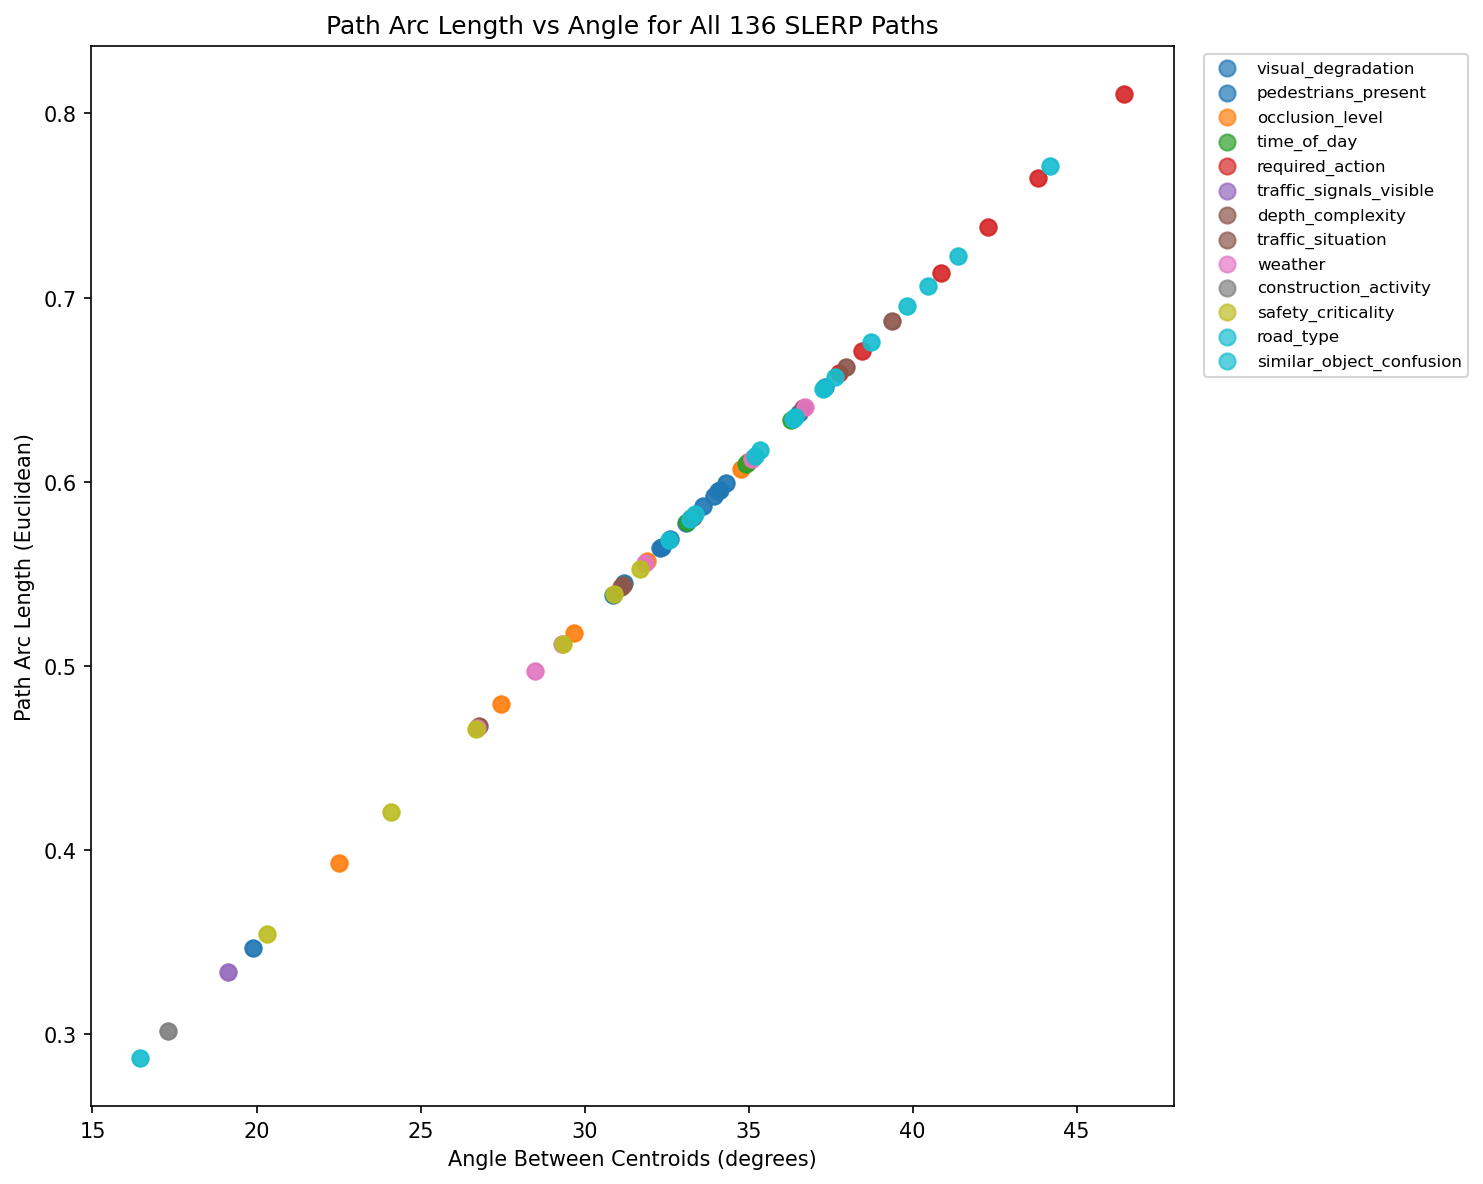

In [13]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

# Color by key
unique_keys = list(set(entry['key'] for entry in metadata))
key_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_keys)))
key_to_color = {k: key_colors[i] for i, k in enumerate(unique_keys)}

for key in unique_keys:
    # Get indices for this key
    indices = [i for i, e in enumerate(metadata) if e['key'] == key]
    thetas = [theta_degrees[i] for i in indices]
    lengths = [arc_lengths[i] for i in indices]
    ax.scatter(thetas, lengths, c=[key_to_color[key]], label=key, alpha=0.7, s=60)

ax.set_xlabel('Angle Between Centroids (degrees)')
ax.set_ylabel('Path Arc Length (Euclidean)')
ax.set_title('Path Arc Length vs Angle for All 136 SLERP Paths')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)

plt.tight_layout()
fig.savefig(FIGURE_DIR / '03_pathlength_vs_angle.png', bbox_inches='tight')
plt.show()

## Summary

The interpolation path visualizations reveal:

1. **Path Distribution**: Shows which attribute keys have the most interpolation pairs
2. **Angle Distribution**: Most centroid pairs are separated by 20-45 degrees in embedding space
3. **SLERP Paths**: The interpolation follows a smooth geodesic path on the hypersphere
4. **Path Length vs Angle**: Larger angles generally correspond to longer arc lengths, as expected for spherical interpolation

In [14]:
# List generated figures
print('Generated figures:')
for f in sorted(FIGURE_DIR.glob('03_*.png')):
    print(f'  {f.name}')

Generated figures:
  03_angle_distribution.png
  03_path_road_highway_intersection.png
  03_path_weather_foggy_clear.png
  03_pathlength_vs_angle.png
  03_paths_per_key.png


## 6. 3D Visualization of SLERP Path: Weather (Foggy to Clear)

A 3D projection of the geodesic interpolation path showing the spherical nature of SLERP.

In [15]:
from mpl_toolkits.mplot3d import Axes3D

def plot_slerp_path_3d(path_idx, metadata, paths, save_name):
    """Visualize a SLERP path in 3D using PCA projection."""
    entry = metadata[path_idx]
    path = paths[path_idx]  # (21, 4096)
    
    # PCA on the path points (3 components)
    pca = PCA(n_components=3, random_state=42)
    coords = pca.fit_transform(path)
    
    # Create figure
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create color gradient along path
    t_normalized = np.linspace(0, 1, len(path))
    colors = plt.cm.coolwarm(t_normalized)
    
    # Plot path as connected line (geodesic curve)
    ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], 'k-', alpha=0.4, linewidth=1.5, zorder=1)
    
    # Plot points with color gradient
    scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], 
                        c=t_normalized, cmap='coolwarm', s=80, 
                        edgecolors='black', linewidth=0.5, zorder=2)
    
    # Mark start and end points
    ax.scatter(coords[0, 0], coords[0, 1], coords[0, 2], c='blue', s=250, marker='s',
               edgecolors='black', linewidth=2, label=f'Start: {entry["value_a"]}', zorder=3)
    ax.scatter(coords[-1, 0], coords[-1, 1], coords[-1, 2], c='red', s=250, marker='s',
               edgecolors='black', linewidth=2, label=f'End: {entry["value_b"]}', zorder=3)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Interpolation t (0=start, 1=end)')
    
    # Labels
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
    
    title = f'3D SLERP Path: {entry["key"]} ({entry["value_a"]} to {entry["value_b"]})'
    ax.set_title(title)
    ax.legend(loc='upper left')
    
    # Set viewing angle
    ax.view_init(elev=20, azim=45)
    
    # Add theta annotation
    total_var = sum(pca.explained_variance_ratio_)
    ax.text2D(0.02, 0.95, f'Angle: {entry["theta_deg"]:.1f} deg\nTotal variance: {total_var:.1%}',
              transform=ax.transAxes, fontsize=10,
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    fig.savefig(FIGURE_DIR / save_name, bbox_inches='tight')
    plt.show()
    
    return entry

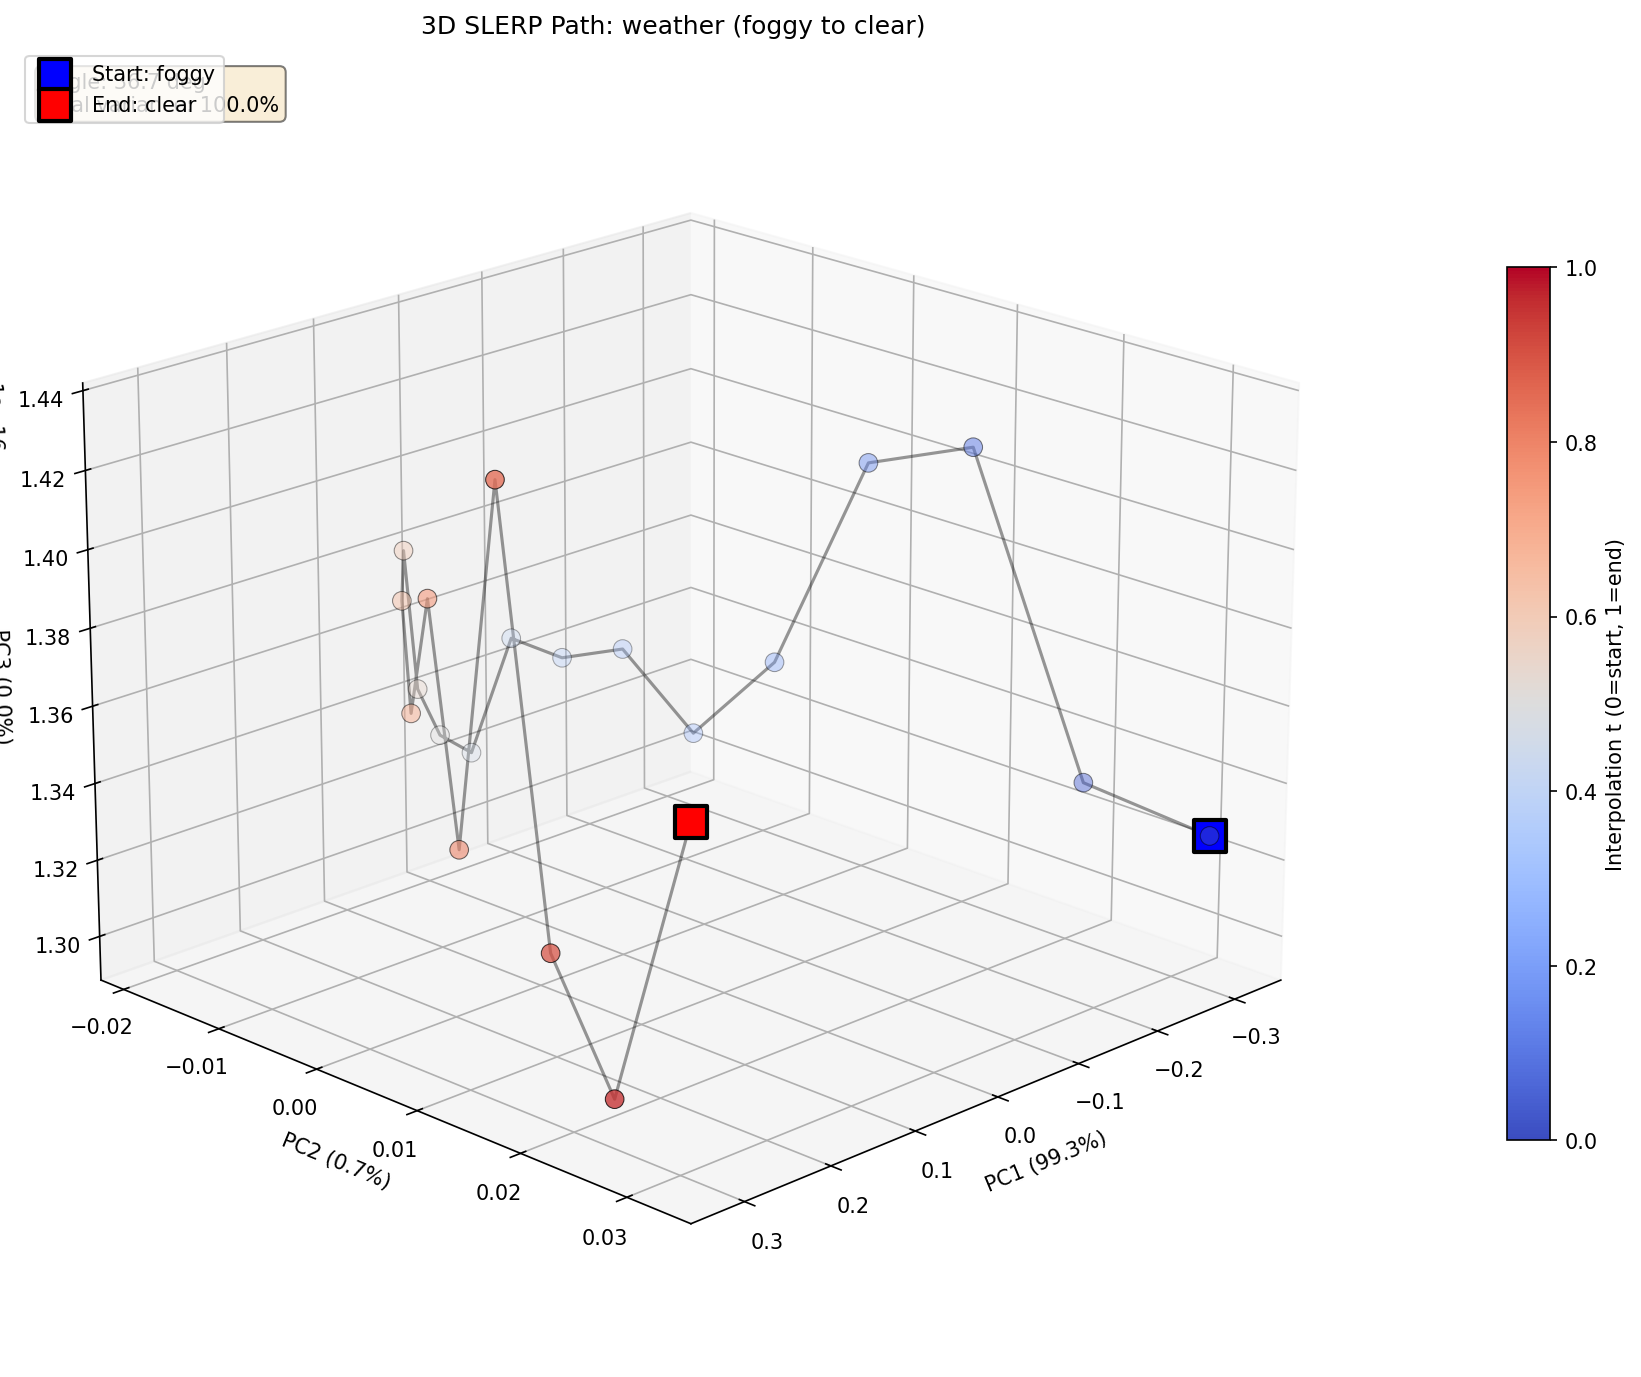

Path index: 0
Theta: 36.71 degrees
Saved: 03_path_3d_weather.png


In [16]:
# Find and plot 3D weather: foggy -> clear path
weather_idx = find_path_index(metadata, 'weather', 'foggy', 'clear')
if weather_idx is not None:
    entry = plot_slerp_path_3d(weather_idx, metadata, paths, '03_path_3d_weather.png')
    print(f'Path index: {weather_idx}')
    print(f'Theta: {entry["theta_deg"]:.2f} degrees')
    print(f'Saved: 03_path_3d_weather.png')
else:
    print('Path not found: weather foggy -> clear')